# Street network processing

Input street network normally represents transportation network. However, that comes with dual lines, roundabouts and other transportation focused features, which causes imprecision of morphometric analysis.

Currently, preprocessing aims to consolidate nodes and edges of street network to get morphological, not trasporation geometry.

`consolidate` and `roundabouts` functions are loaded from `consolidate.py`.

In [1]:
import geopandas as gpd

from consolidate import consolidate, roundabouts

In [2]:
help(consolidate)

Help on function consolidate in module consolidate:

consolidate(network, distance=2, epsilon=2, filter_func=<function filter_comp at 0x7f89f1c369d0>, **kwargs)
    Consolidate edges of a network, takes care of geometry only. No
    attributes are preserved at the moment.
    
    The whole process is split into several steps:
    1. Polygonize network
    2. Find polygons which are likely caused by dual lines and other
       geometries to be consolidated.
    3. Iterate over those polygons and generate averaged geometry
    4. Remove invalid and merge together with new geometry.
    
    Step 2 needs work, this is just a first attempt based on shape and area
    of the polygon. We will have to come with clever options here and
    allow their specification, because each network will need different
    parameters.
    
    Either before or after these steps needs to be done node consolidation,
    but in a way which does not generate overlapping geometries.
    Overlapping geometries 

In [3]:
network = gpd.read_file("https://gist.githubusercontent.com/martinfleis/367b3cb8f5c5a3f2c5b121174ef79990/raw/63290816c4834320233a2588c64317c9f47e3ed6/sample.geojson")

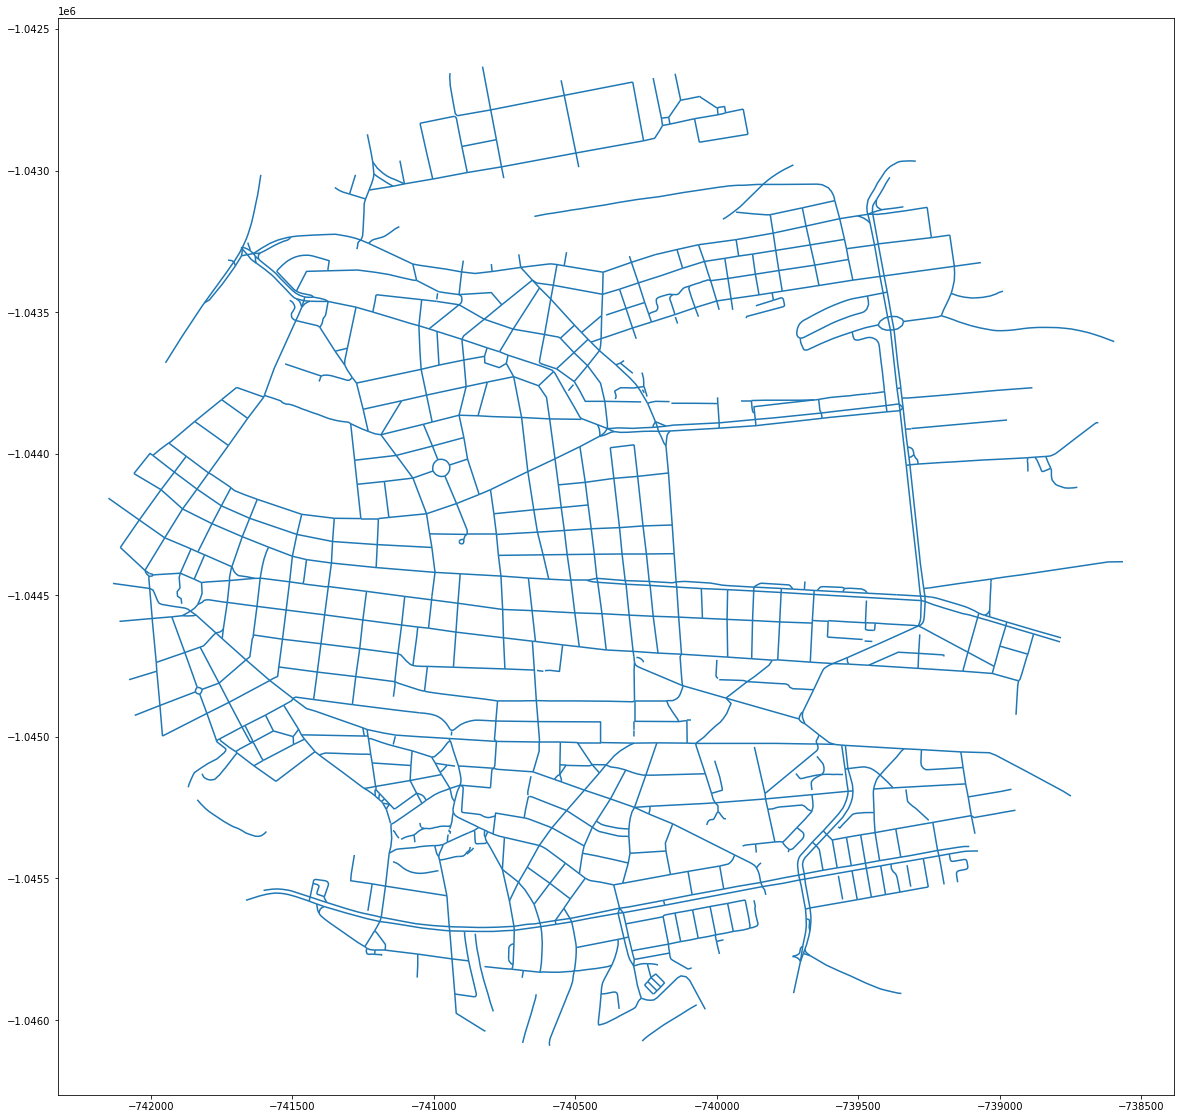

In [4]:
network.plot(figsize=(20, 20))

In [5]:
consolidated = consolidate(network)

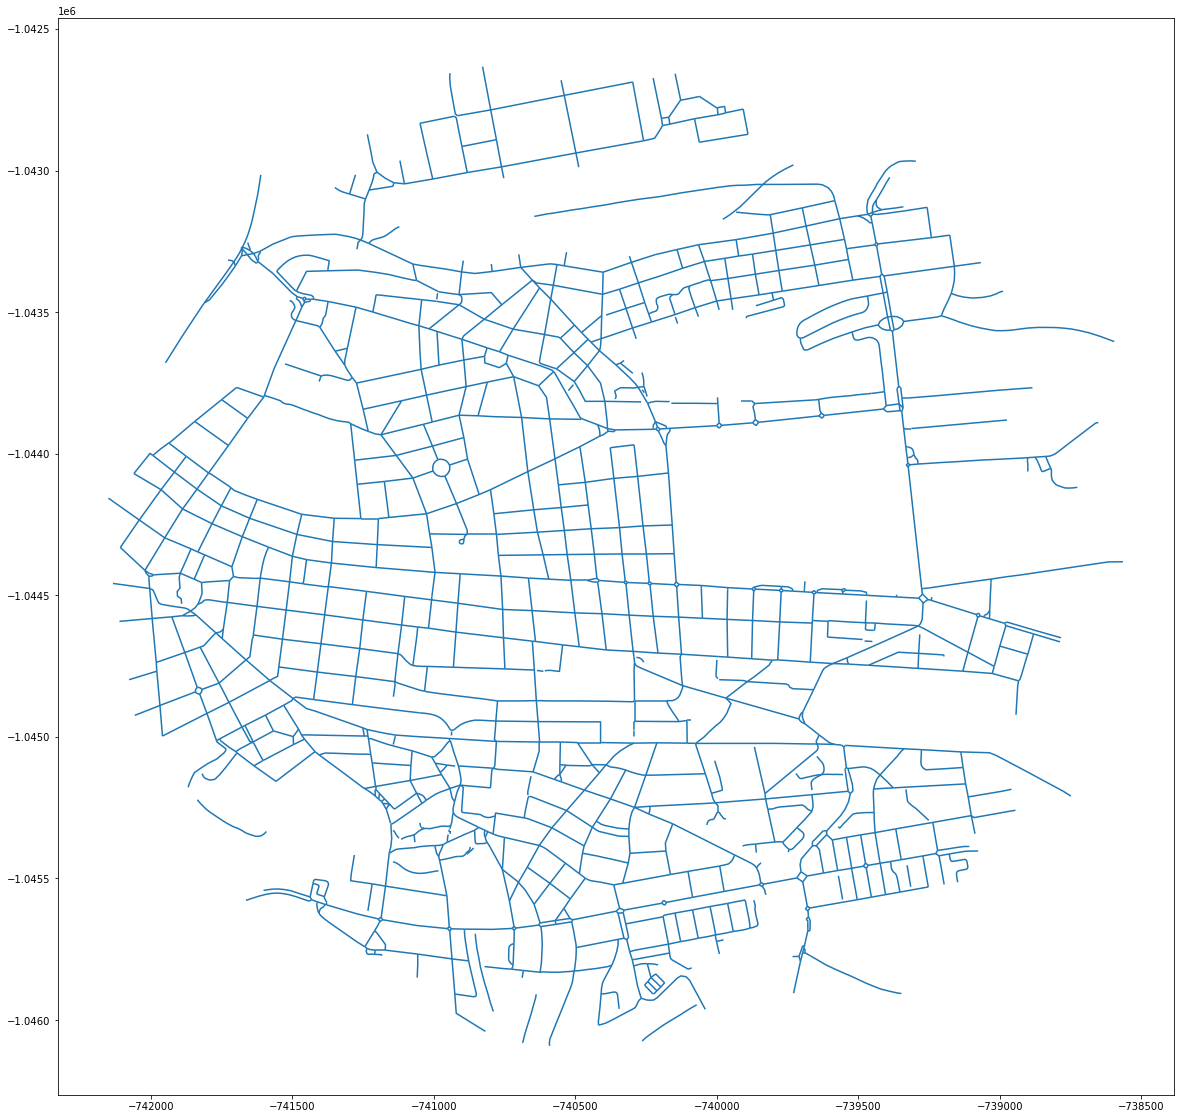

In [6]:
consolidated.plot(figsize=(20, 20))

TODO:

- figure out clever way of adaptable filters (to identify which polygons should not be there, i.e. which edges should be consolidated)
- triple/quadruple lines
- consolidate nodes in geometrical manner before (or after) edge consolidation. Current implementation of node consolidation creates overlapping lines causing issues with Voronoi. The optimal result should be spider-like.
- implementation into OSMnx, which has to deal with a mess of OSM (overlapping geometries)
- make it work for both GeoDataFrames and Graph


## OpenRoads

The main issue on OpenRoads seems to be roundabouts, dual routes are mostly removed already. Some of them have attribute, some not, so we should not depend on it.


In [2]:
from shapely.geometry import Point


pt = Point(335237.8, 396391.6)

df = gpd.read_file('oproad_gpkg_gb/data/oproad_gb.gpkg', mask=pt.buffer(10000))

In [7]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11405 entries, 0 to 11404
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   id                        11405 non-null  object  
 1   endNode                   11405 non-null  object  
 2   startNode                 11405 non-null  object  
 3   roadNumberTOID            1525 non-null   object  
 4   roadNameTOID              9757 non-null   object  
 5   fictitious                11405 non-null  bool    
 6   roadClassification        11405 non-null  object  
 7   roadFunction              11405 non-null  object  
 8   formOfWay                 11405 non-null  object  
 9   length                    11405 non-null  int64   
 10  length_uom                11405 non-null  object  
 11  loop                      11405 non-null  bool    
 12  primaryRoute              11405 non-null  bool    
 13  trunkRoad                 11405 non-nu

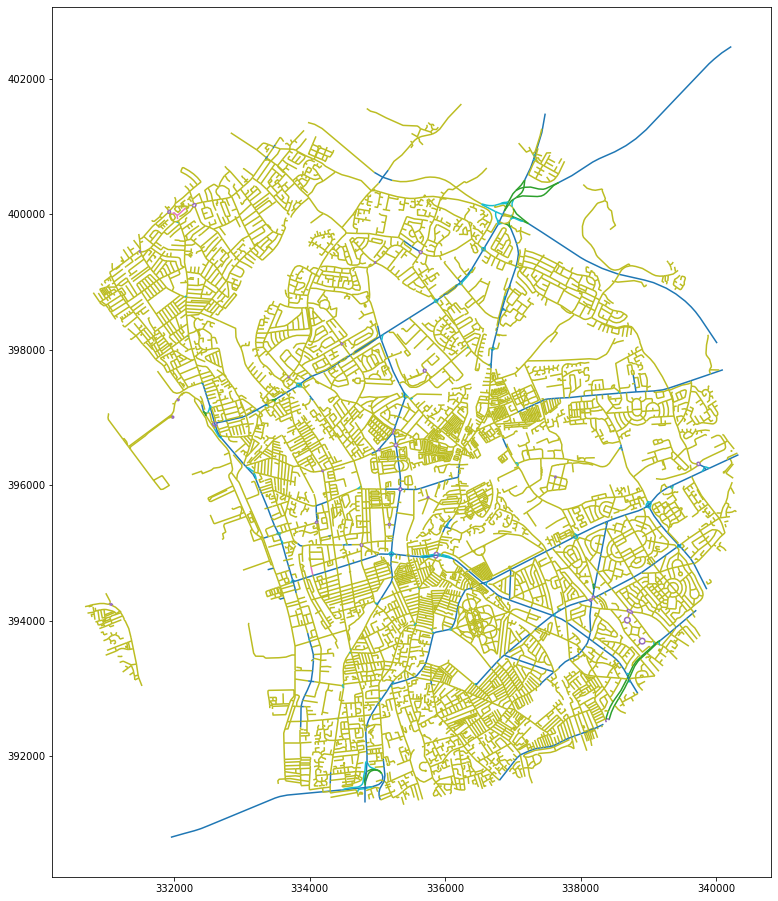

In [8]:
df.plot('formOfWay', figsize=(16, 16))

In [18]:
cons = consolidate(df, filter_func=roundabouts, area=2500, circom=.75)

100%|██████████| 11427/11427 [00:04<00:00, 2608.35it/s]
4it [00:00, 37.18it/s]Merging segments...
613it [00:17, 35.20it/s]


In [3]:
import keplergl

In [4]:
map_1 = keplergl.KeplerGl(height=800)
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(height=800)

In [19]:
map_1.add_data(data=cons.to_crs(4326), name="cons2")

In [5]:
map_1.add_data(data=df.to_crs(4326), name="wider")

- Triangles at intersections ('Slip Road')
- Marked roundabouts
- Unmarked roundabouts
- Small unmarked roundabouts can be square-like
- Avoid unintentional collapsing of some dense roads

I guess it will require combination of a couple of different filters based on the geometry as well as attributes.

In [20]:
df.formOfWay.unique()

array(['Collapsed Dual Carriageway', 'Single Carriageway', 'Slip Road',
       'Dual Carriageway', 'Roundabout', 'Shared Use Carriageway'],
      dtype=object)